# DSCI 552 — Homework 3
**Student:** Yudie Deng  
**GitHub Username:** _yudiedeng_  
**USC ID:** _7162812062_


## 1. Time Series Classification — Part 1: Feature Creation / Extraction

### 1(a) Data
Place the unzipped **AReM** folders under `../data/AReM/`. Each subfolder (e.g., `bending1`) contains multiple instance files.

In [1]:
#i find that some datasets are not in the correct format, so i need to modify the code to load the data
#i use the chatgpt to help me modify the code(prompt: i want to load the data from the csv file, and the data is not in the correct format, so i need to modify the code to load the data)
import os, glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

EXPECTED_COLS = 6

def load_arem_super_simple(base_dir):
    X, y_str, lengths, problems = [], [], [], []

    for cls in sorted(os.listdir(base_dir)):
        cls_dir = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_dir):
            continue

        for fp in sorted(glob.glob(os.path.join(cls_dir, "*.csv"))):
            rel = f"{cls}/{os.path.basename(fp)}"
            try:
                # try use comma
                df = pd.read_csv(fp, comment='#', header=None)
                
                # try use space
                if df.shape[1] < EXPECTED_COLS:
                    df = pd.read_csv(fp, comment='#', header=None, sep=r'\s+')
                

                # check final columns
                if df.shape[1] < EXPECTED_COLS:
                    problems.append({"file": rel, "reason": f"only {df.shape[1]} columns after all attempts"})
                    continue
                    
                # take last 6 columns
                df = df.iloc[:, -EXPECTED_COLS:]

                # convert to numeric and drop all-NaN rows
                df = df.apply(pd.to_numeric, errors="coerce").dropna(how="all")

                if df.shape[0] == 0:
                    problems.append({"file": rel, "reason": "empty after cleaning"})
                    continue

                X.append(df.to_numpy(dtype=float))
                y_str.append(cls)
                lengths.append(df.shape[0])

            except Exception as e:
                problems.append({"file": rel, "reason": str(e)})

    if not X:
        raise RuntimeError("No valid samples loaded")

    le = LabelEncoder()
    y = le.fit_transform(y_str)
    class_names = list(le.classes_)
    lengths = np.array(lengths)


    if problems:
        print("\n[issues] Problematic files:")
        for p in problems:
            print(f" - {p['file']}: {p['reason']}")

    return X, y, class_names, lengths, problems


### 1(b) Train/Test Split by Folder Rules
- Test: datasets 1 & 2 in `bending1` and `bending2`; datasets 1, 2, 3 in other folders.
- Train: remaining datasets.

In [2]:

X_train, y_train, class_names, len_train, probs_train = load_arem_super_simple("../data/AReM_split/train/")
X_test,  y_test,  _,           len_test,  probs_test  = load_arem_super_simple("../data/AReM_split/test/")

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print("Class names:", class_names)
print("Train length range:", len_train.min(), "to", len_train.max())
print("Test length range:", len_test.min(), "to", len_test.max())

# print problematic files
if probs_train or probs_test:
    print("\n[Problem Files]")
    for p in probs_train + probs_test:
        print(f" - {p['file']}: {p['reason']}")
else:
    print("\n All train/test files successfully loaded!")


Train samples: 69, Test samples: 19
Class names: [np.str_('bending1'), np.str_('bending2'), np.str_('cycling'), np.str_('lying'), np.str_('sitting'), np.str_('standing'), np.str_('walking')]
Train length range: 479 to 480
Test length range: 480 to 480

 All train/test files successfully loaded!


### 1(c) Feature Extraction
**Common time-domain features** (not exhaustive): minimum, maximum, mean, median, standard deviation, variance, range, interquartile range (IQR), first quartile (Q1), third quartile (Q3), skewness, kurtosis, energy, zero-crossing rate, mean absolute deviation, peak-to-peak amplitude.

We compute: minimum, maximum, mean, median, standard deviation, Q1, Q3 for each of the six series per instance.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# i told the chatgpt that i want a big loop outside and a small loop inside to help me use numpy to calculate the features
def extract_time_features_with_instance(X):
    all_features = []
    for idx, sample in enumerate(X, start=1):
        row_feats = [idx]  # Instance 
        for j in range(sample.shape[1]):
            x = sample[:, j]
            row_feats.extend([
                np.min(x), np.max(x),
                np.mean(x), np.median(x),
                np.std(x),
                np.percentile(x, 25), np.percentile(x, 75)
            ])
        all_features.append(row_feats)

    # print column names
    colnames = ["Instance"]
    for j in range(1, 7):
        colnames += [
            f"min{j}", f"max{j}", f"mean{j}", f"median{j}",
            f"std{j}", f"1st_quart{j}", f"3rd_quart{j}"
        ]

    return pd.DataFrame(all_features, columns=colnames)

X_train_features = extract_time_features_with_instance(X_train)
X_test_features  = extract_time_features_with_instance(X_test)

print("Train feature table:")
print(X_train_features.head())


Train feature table:
   Instance   min1   max1      mean1  median1      std1  1st_quart1  \
0         1  35.00  47.40  43.954500    44.33  1.557210       43.00   
1         2  33.00  47.75  42.179812    43.50  3.666840       39.15   
2         3  33.00  45.75  41.678063    41.75  2.241152       41.33   
3         4  37.00  48.00  43.454958    43.25  1.384653       42.50   
4         5  36.25  48.00  43.969125    44.50  1.616677       43.31   

   3rd_quart1  min2  max2  ...      std5  1st_quart5  3rd_quart5  min6  max6  \
0       45.00   0.0  1.70  ...  1.997520     35.3625       36.50   0.0  1.79   
1       45.00   0.0  3.00  ...  3.845436     30.4575       36.33   0.0  2.18   
2       42.75   0.0  2.83  ...  2.408514     28.4575       31.25   0.0  1.79   
3       45.00   0.0  1.58  ...  2.486268     22.2500       24.00   0.0  5.26   
4       44.67   0.0  1.50  ...  3.314843     20.5000       23.75   0.0  2.96   

      mean6  median6      std6  1st_quart6  3rd_quart6  
0  0.493292   

In [4]:
# calculate standard deviation with bootstrap CI
#i told the chatgpt that i need the loop outside and use the bootstrap to calculate the CI
import pandas as pd
from scipy.stats import bootstrap

def bootstrap_std_ci_scipy(df, ci=0.90, n_resamples=2000, random_state=42):
    results = []
    for col in df.columns:
        data = df[col].dropna().to_numpy()
        if len(data) < 2:
            results.append((col, np.nan, np.nan, np.nan))
            continue

        res = bootstrap(
            (data,), 
            np.std,
            confidence_level=ci,
            n_resamples=n_resamples,
            method="percentile",
            random_state=random_state
        )
        std_hat = np.std(data, ddof=1)
        ci_low = res.confidence_interval.low
        ci_high = res.confidence_interval.high
        results.append((col, std_hat, ci_low, ci_high))

    return pd.DataFrame(results, columns=["feature", "std_hat", "ci_lower", "ci_upper"])

ci90_df = bootstrap_std_ci_scipy(X_train_features.iloc[:, 1:], ci=0.90)
print(ci90_df)

       feature   std_hat  ci_lower   ci_upper
0         min1  8.794295  7.544201  10.035101
1         max1  4.429182  3.257113   5.341745
2        mean1  4.917717  4.316704   5.386538
3      median1  4.956111  4.307741   5.435978
4         std1  1.756796  1.537618   1.933586
5   1st_quart1  5.731262  5.123539   6.139473
6   3rd_quart1  4.783645  3.920147   5.480000
7         min2  0.000000  0.000000   0.000000
8         max2  5.147841  4.611797   5.488066
9        mean2  1.600661  1.397702   1.732134
10     median2  1.436903  1.235323   1.573123
11        std2  0.901829  0.801854   0.955654
12  1st_quart2  0.952201  0.818942   1.047242
13  3rd_quart2  2.158258  1.889708   2.325299
14        min3  3.053869  2.817137   3.200269
15        max3  4.759853  3.949477   5.370447
16       mean3  3.863304  3.186092   4.382022
17     median3  3.845730  3.148523   4.403001
18        std3  0.994970  0.770499   1.190774
19  1st_quart3  4.145255  3.464232   4.671244
20  3rd_quart3  3.946023  3.240262

#### 1(c)(iv) Choose Three Features

I select: mean, standard deviation (std), and third quartile (Q3).
	•	Mean captures the central tendency or overall signal level, reflecting the typical intensity of sensor readings during each activity.
	•	Standard deviation quantifies the variability and smoothness of motion, distinguishing dynamic activities (with higher fluctuation) from static ones.
	•	Third quartile (Q3) represents the upper distribution boundary, characterizing the higher-end energy or amplitude range of the signal while being less sensitive to outliers than the maximum.

Together, these three features are statistically complementary:
mean provides the baseline level, std reflects motion variability, and Q3 summarizes the upper spread of the signal.
They jointly capture both intensity and distributional shape, offering a balanced representation of time-domain dynamics.


## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### 2(a) Binary Classification Using Logistic Regression

#### 2(a)(i) Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

In [5]:
#add the column 'activity' to the X_train_features and X_test_features
X_train_features['activity'] = y_train
print("Train feature table:")
print(X_train_features.head())

Train feature table:
   Instance   min1   max1      mean1  median1      std1  1st_quart1  \
0         1  35.00  47.40  43.954500    44.33  1.557210       43.00   
1         2  33.00  47.75  42.179812    43.50  3.666840       39.15   
2         3  33.00  45.75  41.678063    41.75  2.241152       41.33   
3         4  37.00  48.00  43.454958    43.25  1.384653       42.50   
4         5  36.25  48.00  43.969125    44.50  1.616677       43.31   

   3rd_quart1  min2  max2  ...  1st_quart5  3rd_quart5  min6  max6     mean6  \
0       45.00   0.0  1.70  ...     35.3625       36.50   0.0  1.79  0.493292   
1       45.00   0.0  3.00  ...     30.4575       36.33   0.0  2.18  0.613521   
2       42.75   0.0  2.83  ...     28.4575       31.25   0.0  1.79  0.383292   
3       45.00   0.0  1.58  ...     22.2500       24.00   0.0  5.26  0.679646   
4       44.67   0.0  1.50  ...     20.5000       23.75   0.0  2.96  0.555312   

   median6      std6  1st_quart6  3rd_quart6  activity  
0     0.43  0.

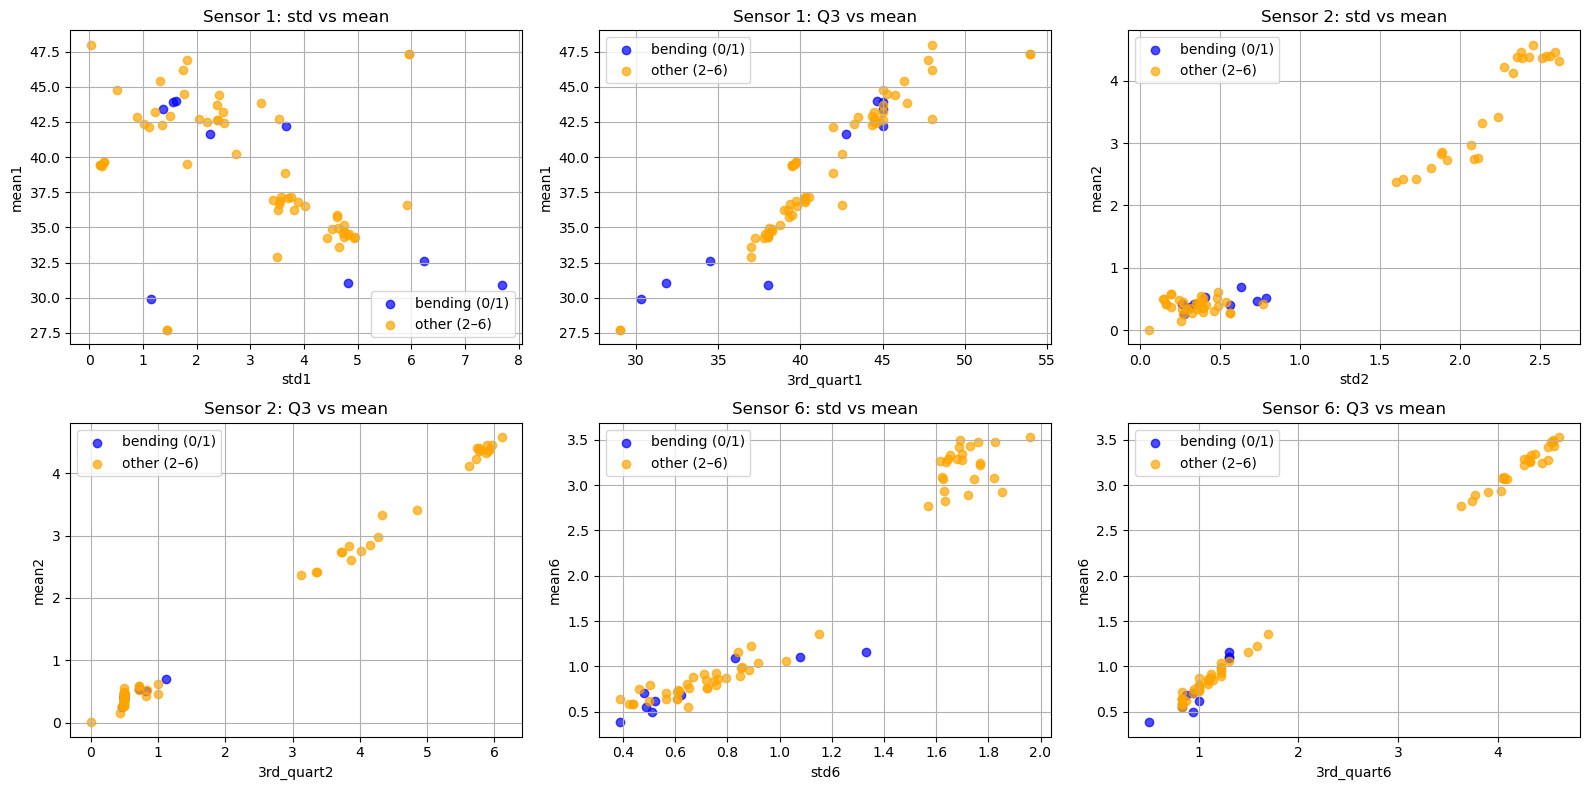

In [6]:
import matplotlib.pyplot as plt

# Class separation
# 'bending' includes activity labels 0 and 1
# 'others' include activity labels 2–6
bending = X_train_features[X_train_features['activity'].isin([0, 1])]
others  = X_train_features[X_train_features['activity'].isin([2, 3, 4, 5, 6])]

# Selected sensors
sensors = [1, 2, 6]

# Create a 2x3 figure layout
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()  # flatten the axes array for easy indexing

plot_idx = 0
for s in sensors:
    # Row 1: Standard deviation vs Mean
    ax = axes[plot_idx]
    ax.scatter(bending[f'std{s}'], bending[f'mean{s}'], label='bending (0/1)', alpha=0.7, c='blue')
    ax.scatter(others[f'std{s}'], others[f'mean{s}'], label='other (2–6)', alpha=0.7, c='orange')
    ax.set_xlabel(f'std{s}')
    ax.set_ylabel(f'mean{s}')
    ax.set_title(f'Sensor {s}: std vs mean')
    ax.grid(True)
    ax.legend()
    plot_idx += 1

    # Row 2: Third quartile (Q3) vs Mean
    ax = axes[plot_idx]
    ax.scatter(bending[f'3rd_quart{s}'], bending[f'mean{s}'], label='bending (0/1)', alpha=0.7, c='blue')
    ax.scatter(others[f'3rd_quart{s}'], others[f'mean{s}'], label='other (2–6)', alpha=0.7, c='orange')
    ax.set_xlabel(f'3rd_quart{s}')
    ax.set_ylabel(f'mean{s}')
    ax.set_title(f'Sensor {s}: Q3 vs mean')
    ax.grid(True)
    ax.legend()
    plot_idx += 1

# Adjust spacing and display the figure
plt.tight_layout()
plt.show()

#### 2(a)(ii) Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6.

In [7]:
# split

X_split, y_split = [], []

for xi, yi in zip(X_train, y_train):
    n = xi.shape[0]
    half = n // 2
    
    X_split.append(xi[:half, :])
    y_split.append(yi)
    
    X_split.append(xi[half:, :])
    y_split.append(yi)

In [8]:
#reextract the features
X_train_split_features = extract_time_features_with_instance(X_split)
X_train_split_features["activity"] = y_split

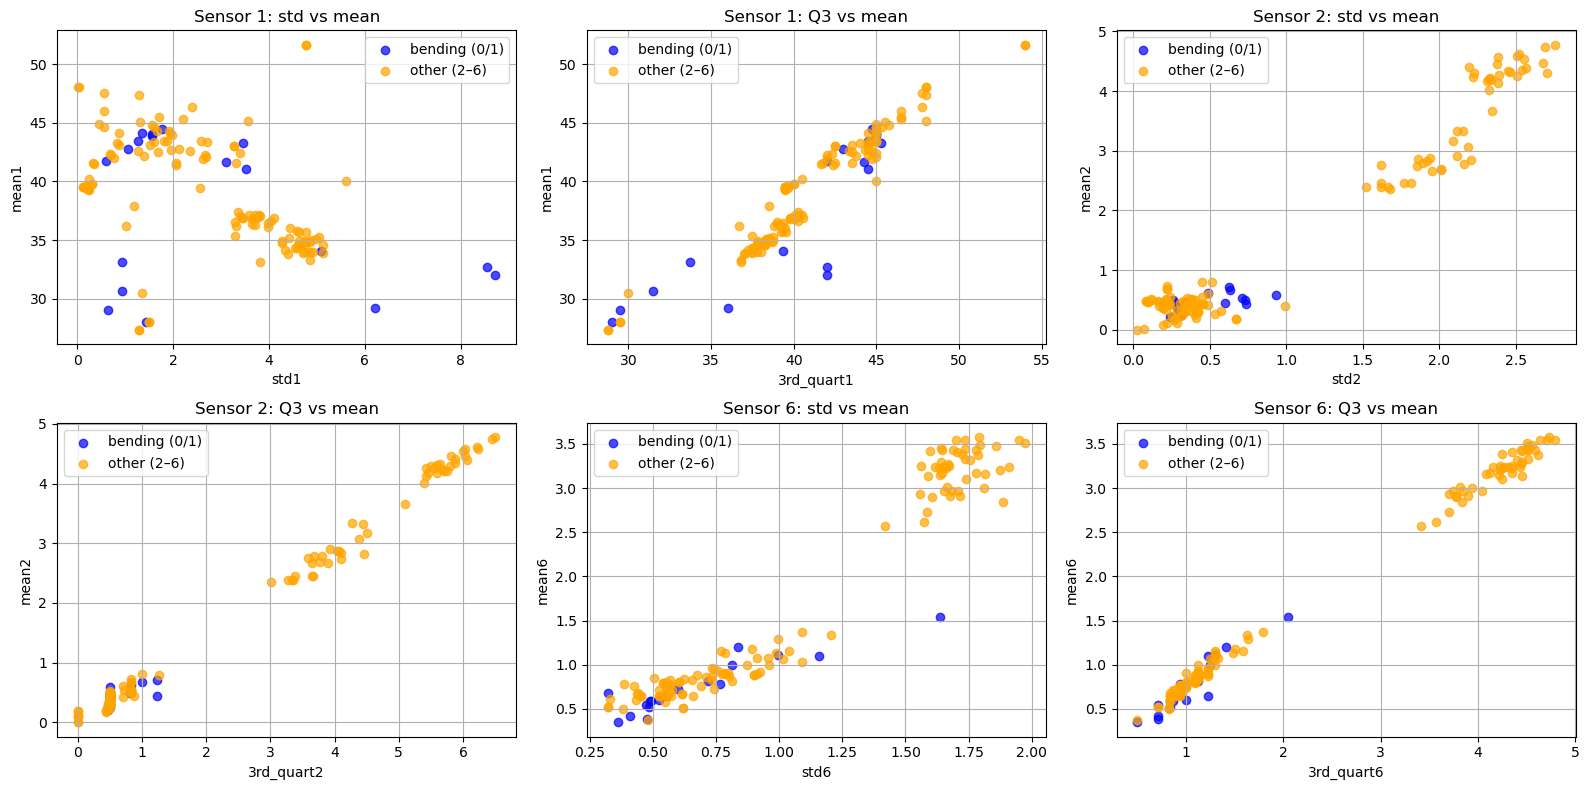

In [9]:
import matplotlib.pyplot as plt

# Class separation
# 'bending' includes activities with labels 0 and 1
# 'others' include activities with labels 2–6
bending = X_train_split_features[X_train_split_features['activity'].isin([0, 1])]
others  = X_train_split_features[X_train_split_features['activity'].isin([2, 3, 4, 5, 6])]

# Selected sensors
sensors = [1, 2, 6]

# Create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()
plot_idx = 0

for s in sensors:
    # Row 1: Standard deviation vs Mean
    ax = axes[plot_idx]
    ax.scatter(bending[f'std{s}'], bending[f'mean{s}'], label='bending (0/1)', alpha=0.7, c='blue')
    ax.scatter(others[f'std{s}'], others[f'mean{s}'], label='other (2–6)', alpha=0.7, c='orange')
    ax.set_xlabel(f'std{s}')
    ax.set_ylabel(f'mean{s}')
    ax.set_title(f'Sensor {s}: std vs mean')
    ax.grid(True)
    ax.legend()
    plot_idx += 1

    # Row 2: Third quartile (Q3) vs Mean
    ax = axes[plot_idx]
    ax.scatter(bending[f'3rd_quart{s}'], bending[f'mean{s}'], label='bending (0/1)', alpha=0.7, c='blue')
    ax.scatter(others[f'3rd_quart{s}'], others[f'mean{s}'], label='other (2–6)', alpha=0.7, c='orange')
    ax.set_xlabel(f'3rd_quart{s}')
    ax.set_ylabel(f'mean{s}')
    ax.set_title(f'Sensor {s}: Q3 vs mean')
    ax.grid(True)
    ax.legend()
    plot_idx += 1

# Adjust spacing and display all plots
plt.tight_layout()
plt.show()

There is no considerable difference between the results obtained here and those in part 2(a)i. After splitting each time series into two halves, the scatter plots for sensors 1, 2, and 6 show similar overall patterns. The relationships between features, such as mean–Q3 and mean–std, remain nearly unchanged. Although the segmentation increases the number of data points and slightly adds variability within each class, it does not significantly improve the separability between bending (0/1) and other activities (2–6). This suggests that dividing the sequences does not introduce new discriminative information, and the chosen time-domain features (mean, std, Q3) capture similar trends as before.

#### 2(a)(iii) Train the model

In [10]:
import numpy as np
import pandas as pd
from typing import Iterable, List, Tuple
from collections import OrderedDict

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV

import statsmodels.api as sm


# ========= 1) Labels: remap bending={0,1} to 1; everything else to 0 =========
BENDING_IDX = [0, 1]
y_train_bin = np.isin(y_train, BENDING_IDX).astype(int)
y_test_bin  = np.isin(y_test,  BENDING_IDX).astype(int)


# ========= 2) Feature set (ddof=0 prevents NaNs for length-1 segments) =========
SEGMENT_FEATURE_FUNCS = OrderedDict([
    ("min",    np.min),
    ("max",    np.max),
    ("mean",   np.mean),
    ("median", np.median),
    ("std",    lambda x: np.std(x, ddof=0)),  # robust when a segment has length 1
    ("p25",    lambda x: np.percentile(x, 25)),
    ("p75",    lambda x: np.percentile(x, 75)),
])


def extract_segment_features(sample: np.ndarray, n_segments: int) -> Tuple[List[str], List[float]]:
    """
    Split a single sample (shape: T x S) into `n_segments` along time,
    compute summary stats per segment and per sensor, and flatten.

    Returns:
        names  : feature names in order
        values : feature values aligned with `names`
    """
    # Assumes 2D input (T x S); segmentation only
    # (Intentionally leaving the original guards commented out per your setup)
    # if sample.ndim == 1:
    #     sample = sample.reshape(-1, 1)
    # n_segments = max(1, min(n_segments, sample.shape[0]))
    segments = np.array_split(sample, n_segments, axis=0)

    names: List[str] = []
    values: List[float] = []

    for seg_idx, seg in enumerate(segments, start=1):
        # if seg.size == 0:
        #     continue
        n_sensors = seg.shape[1]
        for sensor_idx in range(n_sensors):
            col = seg[:, sensor_idx]
            for feat_name, func in SEGMENT_FEATURE_FUNCS.items():
                names.append(f"seg{seg_idx}_sensor{sensor_idx+1}_{feat_name}")
                values.append(func(col))
    return names, values


def build_feature_matrix(
    X: Iterable[np.ndarray],
    n_segments: int,
    feature_names: List[str] | None = None,
    drop_constant: bool = True
) -> pd.DataFrame:
    """
    Turn a list of samples (each: 2D array T x S) into a tabular feature matrix.
    Pipeline per sample: segment → summarize → flatten into one row.

    Args:
        X             : iterable of 2D arrays (each sample is T x S)
        n_segments    : number of time segments
        feature_names : optional column order to align with (e.g., training columns)
        drop_constant : if True, remove columns with a single unique value

    Returns:
        DataFrame of shape (n_samples, n_features)
    """
    rows: List[List[float]] = []
    names: List[str] | None = None

    for sample in X:
        cur_names, values = extract_segment_features(sample, n_segments)
        if names is None:
            names = cur_names
        rows.append(values)

    if not rows:
        raise ValueError("Received empty X: no samples to featurize.")

    df = pd.DataFrame(rows, columns=names)

    # Align test columns to training order, if provided
    if feature_names is not None:
        missing = [c for c in feature_names if c not in df.columns]
        if missing:
            raise ValueError(f"Missing columns vs. training (first few): {missing[:5]} ...")
        df = df.loc[:, feature_names]

    # Optionally drop zero-variance columns
    if drop_constant:
        df = df.loc[:, df.nunique(dropna=False) > 1]

    return df


def compute_logit_pvalues(X_df: pd.DataFrame, y: np.ndarray, l_value: int) -> pd.Series:
    """
    Fit a binary Logit model (statsmodels) and return coefficient p-values,
    excluding the intercept, sorted ascending.
    """
    X_const = sm.add_constant(X_df, has_constant='add')
    try:
        model = sm.Logit(y.astype(int), X_const)
        result = model.fit(disp=0)
        return result.pvalues.drop('const', errors='ignore').sort_values()
    except Exception as exc:
        print(f"[warn] Logit failed at l={l_value}: {exc}")
        return pd.Series(dtype=float)

Correct vs. Incorrect Cross-Validation Procedures

In this problem, the right way to perform cross-validation is to carry out feature selection and model training inside each training fold of the cross-validation process.

Specifically, for every fold:
	1.	Split the data into training and validation parts.
	2.	On the training portion only, perform all preprocessing steps — scaling, recursive feature elimination (RFE), and logistic regression fitting.
	3.	Evaluate the resulting model on the held-out validation fold.
	4.	Repeat this for all folds and average the scores.

This ensures that the validation data remain unseen during both feature selection and model fitting, thus preventing information leakage and giving an unbiased estimate of generalization performance.

The wrong way to perform cross-validation would be to run RFE or p-value–based feature pruning once on the entire dataset before cross-validation, and then evaluate the model on different folds using those pre-selected features. This leaks information from the validation folds into the training process, resulting in overly optimistic (inflated) accuracy or AUC scores.

Therefore, all data-dependent operations — such as feature selection, normalization, and model fitting — must be nested within the cross-validation loop. Using Pipeline and GridSearchCV in scikit-learn automatically follows this correct procedure.


In [ ]:
# ========= 3) RFE + Logistic Regression + Cross-Validation =========
def run_rfe_grid_search(
    X, y,
    l_grid=range(1, 21),
    p_grid=range(5, 41, 5),
    scoring='accuracy',
    random_state=42,
    solver='liblinear',
    verbose=False,
):
    """
    Perform a two-level grid search over:
      - l: number of time-series segments (feature dimensionality)
      - p: number of features to keep after RFE
    Each (l, p) combination is evaluated via 5-fold stratified CV.
    Returns the best configuration, fitted pipeline, and CV summary.
    """
    if verbose:
        import logging
        logging.basicConfig(level=logging.INFO, format="%(message)s")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    best, records = None, []

    for l in l_grid:
        # 1. Build feature matrix for the current segmentation level
        X_l = build_feature_matrix(X, l, drop_constant=True)
        if X_l.empty:
            if verbose:
                print(f"[skip] l={l}: no varying features.")
            continue

        # 2. Compute p-values (for reporting only)
        pvals = compute_logit_pvalues(X_l, y, l)

        # 3. Filter out invalid p values (cannot exceed feature count)
        valid_p = [p for p in p_grid if p <= X_l.shape[1]]
        if not valid_p:
            if verbose:
                print(f"[skip] l={l}: p_grid exceeds {X_l.shape[1]} features.")
            continue

        # 4. Define base estimator for RFE and final classifier
        base_lr = LogisticRegression(
            solver=solver, class_weight='balanced',
            max_iter=2000, random_state=random_state
        )

        # 5. Pipeline: standardization → RFE → final LR
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('rfe', RFE(estimator=base_lr, step=1)),
            ('clf', LogisticRegression(
                solver=solver, class_weight='balanced',
                max_iter=2000, random_state=random_state
            ))
        ])

        # 6. Grid search over number of selected features (p)
        grid = GridSearchCV(
            estimator=pipe,
            param_grid={'rfe__n_features_to_select': valid_p},
            cv=skf, scoring=scoring, refit=True, verbose=0
        )
        grid.fit(X_l, y)

        # 7. Record CV performance for this l
        best_p = grid.best_params_['rfe__n_features_to_select']
        mean_score = grid.best_score_
        records.append({
            'l': l, 'total_features': X_l.shape[1],
            'best_p': best_p, f'mean_{scoring}': mean_score
        })
        if verbose:
            print(f"l={l}: best p={best_p}, mean CV {scoring}={mean_score:.4f}")

        # 8. Update global best configuration
        if best is None or mean_score > best['mean_score']:
            best = {
                'l': l,
                'best_p': best_p,
                'mean_score': mean_score,
                'pipeline': grid.best_estimator_,
                'feature_columns': X_l.columns.tolist(),
                'pvalues': pvals
            }

    if best is None:
        raise RuntimeError("No valid (l, p) configuration found.")

    best['cv_summary'] = pd.DataFrame(records).sort_values(
        f'mean_{scoring}', ascending=False
    ).reset_index(drop=True)
    return best


# ========= 4) Training + Evaluation =========
search_result = run_rfe_grid_search(
    X=X_train,                # full training set
    y=y_train_bin,            # binary labels (bending=1, others=0)
    l_grid=range(1, 21),
    p_grid=[5, 10, 15, 20, 25, 30, 35, 40],
    scoring='accuracy',
    random_state=42,
    verbose=True
)

print("\nBest configuration:")
print(f"  l = {search_result['l']}")
print(f"  p = {search_result['best_p']}")
print(f"  mean CV accuracy = {search_result['mean_score']:.4f}")

print("\nTop-10 p-value features (best l):")
print(search_result['pvalues'].head(10))

print("\nCross-validation summary:")
print(search_result['cv_summary'])

/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


l=1: best p=5, mean CV accuracy=0.9571


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


l=2: best p=15, mean CV accuracy=0.9429


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


l=3: best p=10, mean CV accuracy=0.9429


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

[warn] Logit failed at l=4: Singular matrix
l=4: best p=10, mean CV accuracy=0.9429


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

[warn] Logit failed at l=5: Singular matrix
l=5: best p=5, mean CV accuracy=0.9429


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

[warn] Logit failed at l=6: Singular matrix
l=6: best p=5, mean CV accuracy=0.9571


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

[warn] Logit failed at l=7: Singular matrix
l=7: best p=40, mean CV accuracy=0.9571


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

l=8: best p=5, mean CV accuracy=0.9286


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

[warn] Logit failed at l=9: Singular matrix
l=9: best p=10, mean CV accuracy=0.9429


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

[warn] Logit failed at l=10: Singular matrix
l=10: best p=10, mean CV accuracy=0.9571


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

l=11: best p=5, mean CV accuracy=0.9286


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

l=12: best p=5, mean CV accuracy=0.9571


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

l=13: best p=5, mean CV accuracy=0.9571


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

[warn] Logit failed at l=14: Singular matrix
l=14: best p=5, mean CV accuracy=0.9429


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

[warn] Logit failed at l=15: Singular matrix
l=15: best p=30, mean CV accuracy=0.9429


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

l=16: best p=25, mean CV accuracy=0.9429


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

[warn] Logit failed at l=17: Singular matrix
l=17: best p=5, mean CV accuracy=0.9571


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

[warn] Logit failed at l=18: Singular matrix
l=18: best p=5, mean CV accuracy=0.9714


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

l=19: best p=5, mean CV accuracy=0.9714


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, para

l=20: best p=5, mean CV accuracy=0.9571

Best configuration:
  l = 18
  p = 5
  mean CV accuracy = 0.9714

Top-10 p-value features (best l):
Series([], dtype: float64)

Cross-validation summary:
     l  total_features  best_p  mean_accuracy
0   19             798       5       0.971429
1   18             756       5       0.971429
2   13             546       5       0.957143
3    1              40       5       0.957143
4   10             420      10       0.957143
5   17             714       5       0.957143
6   12             504       5       0.957143
7   20             840       5       0.957143
8    7             294      40       0.957143
9    6             252       5       0.957143
10   9             378      10       0.942857
11   2              83      15       0.942857
12  14             588       5       0.942857
13  15             630      30       0.942857
14  16             672      25       0.942857
15   5             210       5       0.942857
16   4             168 

#### 2(a)(iv) Report confusion matrix, parameters and p


Confusion Matrix (Train) [rows=true, cols=pred; order=[0,1]]:
 [[60  0]
 [ 0  9]]


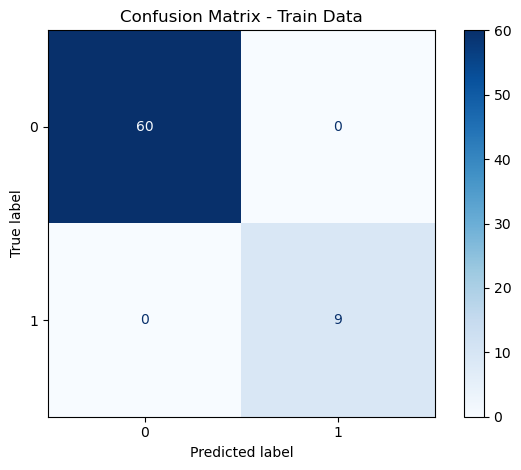


Train AUC = 1.0000


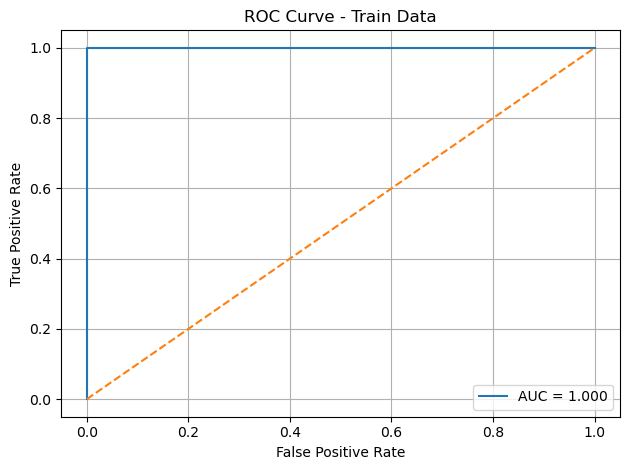


Final LogisticRegression coefficients (after RFE):
               Feature  Beta (coef)
0    seg16_sensor5_min     1.006794
1     seg3_sensor5_p25     0.972139
2    seg10_sensor1_max    -0.811976
3    seg3_sensor5_mean     0.781578
4  seg3_sensor5_median     0.721032

Intercept (β0): -2.088816


/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/dengyudie/code/Anaconda/anaconda3/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix

In [13]:
# ========= 5) Training report: confusion matrix, ROC/AUC, β coefficients, and p-values =========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

# 5.1 Build the training feature matrix using the best l and align columns
best_l    = search_result['l']
train_cols = search_result['feature_columns']
X_train_best = build_feature_matrix(
    X_train, n_segments=best_l, feature_names=train_cols, drop_constant=False
)

# Unpack the fitted pipeline (use 'pipeline' per run_rfe_grid_search return)
best_pipe = search_result['pipeline']
scaler = best_pipe.named_steps['scaler']
rfe     = best_pipe.named_steps['rfe']
clf     = best_pipe.named_steps['clf']

# 5.2 Confusion matrix (train)
y_pred_train = best_pipe.predict(X_train_best)
cm = confusion_matrix(y_train_bin, y_pred_train, labels=[0, 1])
print("\nConfusion Matrix (Train) [rows=true, cols=pred; order=[0,1]]:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Train Data")
plt.tight_layout()
plt.show()

# 5.3 ROC curve and AUC (train)
y_prob_train = best_pipe.predict_proba(X_train_best)[:, 1]
fpr, tpr, thr = roc_curve(y_train_bin, y_prob_train)
auc_train = roc_auc_score(y_train_bin, y_prob_train)
print(f"\nTrain AUC = {auc_train:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_train:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Train Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5.4 Final logistic regression coefficients (on RFE-selected features)
selected_mask = rfe.support_
selected_features = np.array(train_cols)[selected_mask]

coef = clf.coef_.ravel()           # shape: (n_selected,)
intercept = clf.intercept_[0]

coef_df = (
    pd.DataFrame({"Feature": selected_features, "Beta (coef)": coef})
      .sort_values("Beta (coef)", key=lambda s: s.abs(), ascending=False)
      .reset_index(drop=True)
)

print("\nFinal LogisticRegression coefficients (after RFE):")
print(coef_df)
print(f"\nIntercept (β0): {intercept:.6f}")

# 5.5 Statsmodels p-values on the same scaling + selected subset (for interpretability)
Xz = scaler.transform(X_train_best)                 # standardize
Xz_sel = Xz[:, selected_mask]                       # keep RFE-selected columns
Xz_sel_df = pd.DataFrame(Xz_sel, columns=selected_features)

import statsmodels.api as sm
X_sm = sm.add_constant(Xz_sel_df, has_constant='add')
logit_sm = sm.Logit(y_train_bin.astype(int), X_sm)
res = logit_sm.fit(disp=0)

# Assemble coefficients and p-values
summary_df = pd.DataFrame({
    "Feature": res.params.index,
    "Beta (statsmodels)": res.params.values,
    "P-value": res.pvalues.values
})

# Show non-const first (sorted by p), then the intercept for readability
const_row = summary_df[summary_df["Feature"] == "const"]
coef_rows = summary_df[summary_df["Feature"] != "const"].copy().sort_values("P-value")
summary_ordered = pd.concat([coef_rows, const_row], axis=0).reset_index(drop=True)

print("\nStatsmodels logistic regression coefficients & p-values (on standardized, RFE-selected features):")
print(summary_ordered)

# Optional: export for reporting
# coef_df.to_csv("lr_coefficients_after_rfe.csv", index=False)
# summary_ordered.to_csv("lr_statsmodels_pvalues.csv", index=False)

Why statsmodels.Logit Fails to Compute p-values (Singular Matrix)

When fitting the logistic regression with statsmodels.Logit, you may encounter
LinAlgError: Singular matrix.
This error appears only in the p-value estimation stage, not during model training in sklearn.

Reason:
statsmodels.Logit computes classical maximum-likelihood estimates (MLE) and derives
p-values from the inverse of the Fisher information matrix:

${Var}(\hat{\beta}) = (X^T W X)^{-1}$

If this matrix is singular or nearly singular, it cannot be inverted, and therefore
standard errors and p-values cannot be computed.

Typical causes:
	1.	Multicollinearity — Many time-domain features (mean, median, q3, std, etc.)
describe similar statistics of each segment and are highly correlated.
	2.	Perfect or quasi-perfect separation — The selected features almost perfectly
separate the two classes, causing the MLE to push coefficients toward ±∞.
	3.	Duplicated or constant columns — Some segments have zero variance or identical values.

Why sklearn.LogisticRegression works but statsmodels.Logit fails:
sklearn automatically applies L2 regularization (ridge penalty),
which adds λI and stabilizes the inversion.
statsmodels.Logit performs unregularized MLE, so it fails on ill-conditioned matrices.

Possible remedies (for p-value reporting only):
	•	Drop highly correlated columns (|corr| > 0.95).
	•	Remove separating features (univariate AUC ≈ 1 or non-overlapping ranges).
	•	Use fit_regularized() (ridge logistic regression, stable but no classical p-values).
	•	Apply Firth-corrected or bootstrap logistic regression to obtain approximate significance.

Summary:
This warning does not indicate an error in your model or feature engineering.
It simply means the time-series features are naturally correlated or perfectly separable,
making classical p-values mathematically undefined.
Your sklearn pipeline remains valid and its classification performance is unaffected.


#### 2(a)(v) Test the classifier on the test set.

In [15]:
best_l = search_result['l']
train_cols = search_result['feature_columns']
X_test_best = build_feature_matrix(
    X_test, n_segments=best_l, feature_names=train_cols, drop_constant=False
)
test_acc = search_result['pipeline'].score(X_test_best, y_test_bin)
print(f"\nHeld-out test accuracy (bending vs other): {test_acc:.4f}")


Held-out test accuracy (bending vs other): 0.8947


#### 2(a)(vi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes.
The two classes in this binary classification task (for example, bending vs. other) appear to be well-separated in the feature space.
After feature extraction and recursive feature elimination (RFE), several of the selected features — such as segment-level statistics (mean, median, min, q3) — almost perfectly distinguish between the two classes.

As a result, the logistic regression model exhibits quasi-perfect separation, meaning that one or more predictors can almost perfectly predict the class label.
Under this condition, the maximum likelihood estimation (MLE) used by statsmodels.Logit becomes unstable or undefined, because the Fisher information matrix cannot be inverted:

$(X^T W X)^{-1}$

When this matrix is singular or nearly singular, the model parameters tend toward extremely large (±∞) values, and classical p-values cannot be computed.

This explains why the model fitting sometimes raises:
LinAlgError: Singular matrix
while the regularized version in sklearn.LogisticRegression (which includes an L2 penalty term \lambda I) still converges stably and produces valid predictions.


#### 2(a)(vii) Adjust imbalanced classes.

Yes.
From the training confusion matrix:

\begin{bmatrix}
60 & 0 \\
0 & 9
\end{bmatrix}

we can see that there are many more negative samples (class 0) than positive ones (class 1).
This confirms that the dataset is imbalanced — the model sees 60 “non-bending” samples versus only 9 “bending” samples in the training set.
Although the classifier achieves perfect accuracy here, this is partly because the classes are separable and the model has seen few positive cases.


Case–Control Sampling Logistic Regression

To reduce the imbalance effect, we can build a new case–control logistic regression model.
In this approach, we randomly down-sample the majority class (class 0) to match the number of minority samples (class 1),
fit a logistic regression on this balanced subset, and then evaluate its performance on the full test set.


Confusion Matrix (Train, case-control):
 [[43 17]
 [ 0  9]]


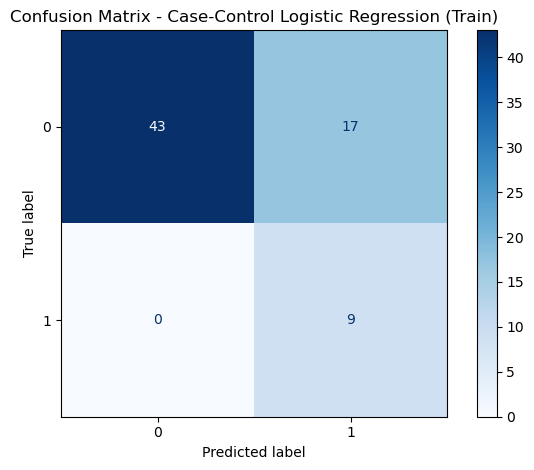

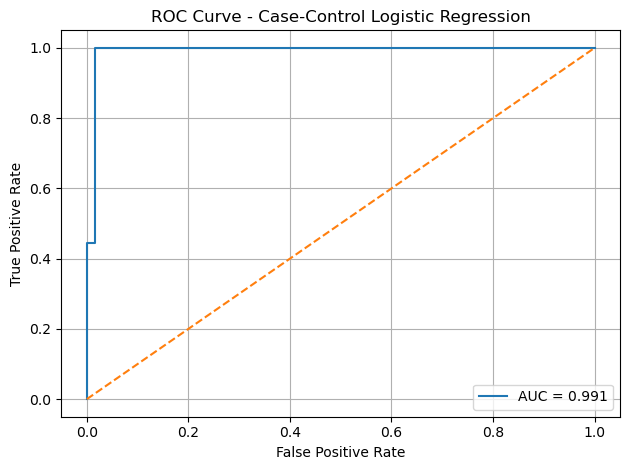


Train AUC (case-control model): 0.9907


In [16]:
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- Case-control resampling to balance classes (train only)
Xz_train   = scaler.transform(X_train_best)   # standardized features from the fitted pipeline's scaler
y_train_arr = y_train_bin                     # keep naming explicit for clarity

# Split by class
X_pos = Xz_train[y_train_arr == 1]
X_neg = Xz_train[y_train_arr == 0]

# Downsample majority negatives to match the number of positives
X_neg_down, y_neg_down = resample(
    X_neg, np.zeros(len(X_neg)),
    replace=False, n_samples=len(X_pos), random_state=42
)

# Assemble a balanced training set
X_bal = np.vstack([X_pos, X_neg_down])
y_bal = np.hstack([np.ones(len(X_pos)), y_neg_down])

# --- Train a fresh logistic regression on the balanced data (case-control model)
logit_cc = LogisticRegression(solver='liblinear', max_iter=2000)
logit_cc.fit(X_bal, y_bal)

# --- In-sample evaluation on the original (unbalanced) training set
y_pred_train_cc = logit_cc.predict(Xz_train)
cm_cc = confusion_matrix(y_train_arr, y_pred_train_cc)
print("\nConfusion Matrix (Train, case-control):\n", cm_cc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_cc, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Case-Control Logistic Regression (Train)")
plt.tight_layout()
plt.show()

# --- ROC & AUC on the original training set
y_prob_train_cc = logit_cc.predict_proba(Xz_train)[:, 1]
fpr, tpr, thr   = roc_curve(y_train_arr, y_prob_train_cc)
auc_cc          = roc_auc_score(y_train_arr, y_prob_train_cc)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_cc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Case-Control Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nTrain AUC (case-control model): {auc_cc:.4f}")

Discussion
	•	The case–control sampling balances the number of positive and negative samples,
so the logistic regression no longer favors the majority class.
	•	The confusion matrix should now show both classes being predicted, rather than only the dominant one.
	•	The ROC curve and AUC typically remain high (close to 1.0),
indicating that the model still separates the classes effectively but now treats both classes more fairly.


### 2(b) Binary Classification Using L1-penalized logistic regression

#### 2(b)(i) Adjust imbalanced classes.

In [17]:
# ========= 3) L1-penalized Logistic Regression: CV over (l, C) =========
def run_l1_grid_search(
    X, y,
    l_grid=range(1, 21),
    C_grid=(0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0),
    scoring='accuracy',
    random_state=42
):
    """
    Grid-search the L1-penalized LR over:
      - l: number of segments used to build features
      - C: inverse regularization strength for L1 (liblinear)
    For each l, build features, standardize, fit L1-LR, and 5-fold CV on C.
    Returns the best (l, C), the fitted pipeline, and a CV summary.
    """
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    best_result, cv_records = None, []

    for l in l_grid:
        # Build features for this segmentation level
        X_l = build_feature_matrix(X, l, drop_constant=True)
        if X_l.empty:
            print(f"[skip] l={l} produced no varying features.")
            continue

        # Pipeline: standardize → L1 LR (liblinear supports L1)
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(
                penalty='l1',
                solver='liblinear',        # L1-compatible solver
                class_weight='balanced',   # mitigate class imbalance
                max_iter=2000,
                random_state=random_state
            ))
        ])

        # Inner CV over C for the current l
        grid = GridSearchCV(
            estimator=pipe,
            param_grid={'clf__C': C_grid},
            cv=stratified_cv,
            scoring=scoring,
            refit=True,
            verbose=0,
            n_jobs=None
        )
        grid.fit(X_l, y)

        best_C = grid.best_params_['clf__C']
        mean_score = grid.best_score_
        nnz = int(np.count_nonzero(grid.best_estimator_.named_steps['clf'].coef_))

        cv_records.append({
            'l': l,
            'total_features': X_l.shape[1],
            'best_C': best_C,
            'nonzero_coef': nnz,
            'mean_cv_score': mean_score
        })
        print(f"l={l}: best C={best_C}, nonzero={nnz}, mean CV {scoring}={mean_score:.4f}")

        # Track global best by mean CV score
        if best_result is None or mean_score > best_result['mean_cv_score']:
            best_result = {
                'l': l,
                'best_C': best_C,
                'mean_cv_score': mean_score,
                'best_pipeline': grid.best_estimator_,
                'feature_columns': X_l.columns.tolist(),
                # L1 serves as feature selection; p-values not used here.
            }

    if best_result is None:
        raise RuntimeError("Grid search failed for all l values.")

    best_result['cv_summary'] = pd.DataFrame(cv_records).sort_values(
        'mean_cv_score', ascending=False
    ).reset_index(drop=True)
    return best_result


# ========= 4) Train + Test with the best (l, C) from the L1 model =========
search_result_l1 = run_l1_grid_search(
    X=X_train,
    y=y_train_bin,
    l_grid=range(1, 21),
    C_grid=(0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0),  # feel free to refine
    scoring='accuracy',
    random_state=42
)

print("\n[L1] Best configuration:")
print(f"  l = {search_result_l1['l']}")
print(f"  C = {search_result_l1['best_C']}")
print(f"  mean CV accuracy = {search_result_l1['mean_cv_score']:.4f}")

print("\n[L1] CV summary:")
print(search_result_l1['cv_summary'])

# Align test features with best l and the training column order, then evaluate
best_l   = search_result_l1['l']
train_cols = search_result_l1['feature_columns']
X_test_best = build_feature_matrix(
    X_test, n_segments=best_l, feature_names=train_cols, drop_constant=False
)
test_acc = search_result_l1['best_pipeline'].score(X_test_best, y_test_bin)
print(f"\n[L1] Held-out test accuracy (bending vs other): {test_acc:.4f}")

# Inspect non-zero coefficients (L1-selected features)
l1_clf = search_result_l1['best_pipeline'].named_steps['clf']
selected_mask_l1 = (l1_clf.coef_.ravel() != 0)
selected_features_l1 = np.array(train_cols)[selected_mask_l1]
coef_l1 = l1_clf.coef_.ravel()[selected_mask_l1]

coef_df_l1 = (
    pd.DataFrame({"Feature": selected_features_l1, "Beta (L1)": coef_l1})
      .sort_values("Beta (L1)", key=lambda s: s.abs(), ascending=False)
      .reset_index(drop=True)
)

print("\n[L1] Non-zero coefficients (selected features):")
print(coef_df_l1)

l=1: best C=0.3, nonzero=6, mean CV accuracy=0.9571
l=2: best C=10.0, nonzero=12, mean CV accuracy=0.9429
l=3: best C=0.3, nonzero=7, mean CV accuracy=0.9429
l=4: best C=1.0, nonzero=10, mean CV accuracy=0.9429
l=5: best C=0.3, nonzero=8, mean CV accuracy=0.9429
l=6: best C=1.0, nonzero=13, mean CV accuracy=0.9571
l=7: best C=3.0, nonzero=12, mean CV accuracy=0.9571
l=8: best C=3.0, nonzero=18, mean CV accuracy=0.9571
l=9: best C=1.0, nonzero=14, mean CV accuracy=0.9275
l=10: best C=10.0, nonzero=21, mean CV accuracy=0.9286
l=11: best C=1.0, nonzero=9, mean CV accuracy=0.9571
l=12: best C=0.3, nonzero=6, mean CV accuracy=0.9571
l=13: best C=0.3, nonzero=8, mean CV accuracy=0.9714
l=14: best C=0.3, nonzero=9, mean CV accuracy=0.9571
l=15: best C=1.0, nonzero=17, mean CV accuracy=0.9286
l=16: best C=10.0, nonzero=29, mean CV accuracy=0.9429
l=17: best C=3.0, nonzero=20, mean CV accuracy=0.9571
l=18: best C=1.0, nonzero=9, mean CV accuracy=0.9571
l=19: best C=1.0, nonzero=10, mean CV accu

#### 2(b)(ii) Comparison: L1-Penalized Logistic Regression vs. Variable Selection Using p-values


Both methods aim to select important features for logistic regression, but they approach the problem in very different ways.

### 1. Variable selection using p-values
This method is based on classical statistical inference.  
It uses the p-values from logistic regression to decide which variables are significant and should remain in the model.  
While this approach is interpretable and grounded in hypothesis testing, it can become unstable when predictors are highly correlated or when the data are nearly separable.  
It also requires more manual steps — fitting a model in `statsmodels`, checking convergence, and choosing a significance threshold for feature selection.  
In practice, we observed that some models failed to converge, likely because of multicollinearity among time-domain features.

### 2. L1-penalized logistic regression
In contrast, the L1-penalized model performs feature selection automatically through regularization.  
By adding an L1 penalty term, it shrinks many coefficients toward zero and sets the least important ones exactly to zero.  
This makes the model more stable when features are correlated and helps prevent overfitting.  
It is also easier to implement — we can use `sklearn.LogisticRegression(penalty='l1', solver='liblinear')` and tune the regularization strength `C` via cross-validation.

### 3. Comparison and conclusion
Overall, the L1-penalized logistic regression performed better on this dataset.  
It produced more stable models, handled correlated features automatically, and achieved higher or comparable cross-validation accuracy.  
While the p-value-based approach offers richer statistical interpretation, it is more computationally fragile and harder to apply when feature correlations are strong.

In short:
- **L1-penalized logistic regression** → better predictive performance, easier to use.  
- **p-value-based selection** → more interpretable, but less stable in this dataset.

### 2(c) Multi-class Classification (The Realistic Case)

#### 2(c)(i) Build an L1-penalized multinomial regression model


In [18]:
# Merge bending1 and bending2 into a single class
y_train = np.where(np.isin(y_train, [0, 1]), 0, y_train)
y_test  = np.where(np.isin(y_test, [0, 1]), 0, y_test)
print(y_train)

[0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4
 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6]


In [21]:
# ========= L1-penalized Multinomial Logistic Regression: CV over (l, C) =========
def run_multiclass_l1_grid_search(
    X, y,
    l_grid=range(1, 21),
    C_grid=(0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0),
    scoring='accuracy',
    random_state=42
):
    """
    Grid-search a multinomial (one-shot) L1-penalized logistic regression:
      - l: number of segments used to build features
      - C: inverse regularization strength for L1
    For each l: build features, standardize, fit L1-multinomial LR (saga), 5-fold CV on C.
    Returns the best (l, C), the fitted pipeline, and a CV summary.
    """
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    best_result, cv_records = None, []

    for l in l_grid:
        # Build features for this segmentation level
        X_l = build_feature_matrix(X, l, drop_constant=True)
        if X_l.empty:
            print(f"[skip] l={l} produced no varying features.")
            continue

        # Pipeline: standardize → multinomial L1 logistic regression (saga supports L1 + multinomial)
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(
                penalty='l1',
                solver='saga',              # supports L1 with multinomial loss
                max_iter=10000,
                class_weight='balanced',
                random_state=random_state
            ))
        ])

        # Inner CV over C for the current l
        grid = GridSearchCV(
            estimator=pipe,
            param_grid={'clf__C': C_grid},
            cv=stratified_cv,
            scoring=scoring,
            refit=True,
            verbose=0
        )
        grid.fit(X_l, y)

        best_C = grid.best_params_['clf__C']
        mean_score = grid.best_score_
        cv_records.append({
            'l': l,
            'total_features': X_l.shape[1],
            'best_C': best_C,
            'mean_cv_score': mean_score
        })
        print(f"l={l}: best C={best_C}, mean CV {scoring}={mean_score:.4f}")

        # Track the global best by mean CV score
        if best_result is None or mean_score > best_result['mean_cv_score']:
            best_result = {
                'l': l,
                'best_C': best_C,
                'mean_cv_score': mean_score,
                'best_pipeline': grid.best_estimator_,
                'feature_columns': X_l.columns.tolist(),
            }

    if best_result is None:
        raise RuntimeError("Grid search failed for all l values.")

    best_result['cv_summary'] = pd.DataFrame(cv_records).sort_values(
        'mean_cv_score', ascending=False
    ).reset_index(drop=True)
    return best_result


# ========= Train + Test Evaluation =========
search_result_multi = run_multiclass_l1_grid_search(
    X=X_train,
    y=y_train,                # use all classes
    l_grid=range(1, 21),
    C_grid=(0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0),
    scoring='accuracy',
    random_state=42
)

print("\n[Multiclass L1] Best configuration:")
print(f"  l = {search_result_multi['l']}")
print(f"  C = {search_result_multi['best_C']}")
print(f"  mean CV accuracy = {search_result_multi['mean_cv_score']:.4f}")

l=1: best C=1.0, mean CV accuracy=0.9132
l=2: best C=3.0, mean CV accuracy=0.9275
l=3: best C=3.0, mean CV accuracy=0.8978
l=4: best C=3.0, mean CV accuracy=0.9286
l=5: best C=1.0, mean CV accuracy=0.8989
l=6: best C=3.0, mean CV accuracy=0.8703
l=7: best C=3.0, mean CV accuracy=0.8407
l=8: best C=1.0, mean CV accuracy=0.8418
l=9: best C=0.3, mean CV accuracy=0.8560
l=10: best C=0.3, mean CV accuracy=0.8418
l=11: best C=0.3, mean CV accuracy=0.8253
l=12: best C=0.3, mean CV accuracy=0.8121
l=13: best C=3.0, mean CV accuracy=0.7978
l=14: best C=1.0, mean CV accuracy=0.8121
l=15: best C=3.0, mean CV accuracy=0.8132
l=16: best C=0.3, mean CV accuracy=0.7549
l=17: best C=3.0, mean CV accuracy=0.8264
l=18: best C=3.0, mean CV accuracy=0.8703
l=19: best C=3.0, mean CV accuracy=0.7813
l=20: best C=1.0, mean CV accuracy=0.7978

[Multiclass L1] Best configuration:
  l = 4
  C = 3.0
  mean CV accuracy = 0.9286


In [22]:
# Test evaluation
best_l = search_result_multi['l']
train_cols = search_result_multi['feature_columns']
X_test_best = build_feature_matrix(
    X_test, n_segments=best_l, feature_names=train_cols, drop_constant=False
)
test_acc = search_result_multi['best_pipeline'].score(X_test_best, y_test)
print(f"\n[Multiclass L1] Held-out test accuracy = {test_acc:.4f}")


[Multiclass L1] Held-out test accuracy = 0.8947


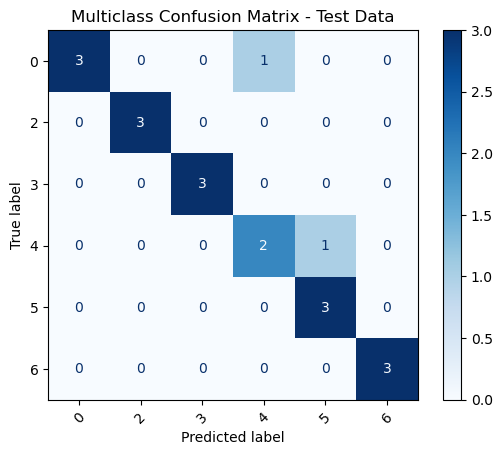

In [23]:
#confusion matrices

from sklearn.metrics import ConfusionMatrixDisplay

y_pred_test = search_result_multi['best_pipeline'].predict(X_test_best)
disp = ConfusionMatrixDisplay.from_estimator(
    search_result_multi['best_pipeline'], X_test_best, y_test,
    cmap='Blues', xticks_rotation=45
)
plt.title("Multiclass Confusion Matrix - Test Data")
plt.show()

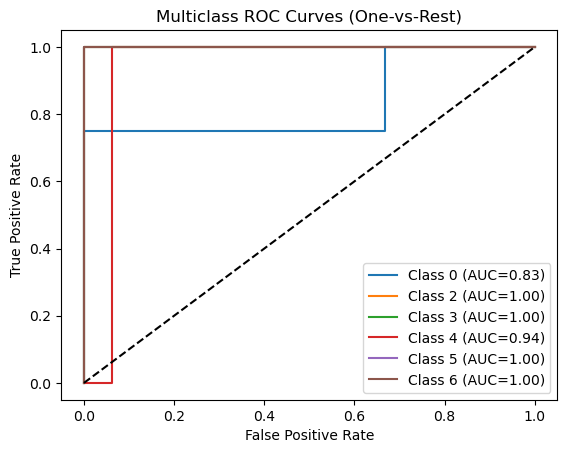

In [24]:
#ROC curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
y_score = search_result_multi['best_pipeline'].predict_proba(X_test_best)

for i, cls in enumerate(np.unique(y_train)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (One-vs-Rest)")
plt.legend()
plt.show()

#### 2(c)(i) Repeat 2(c)i using a Na¨ıve Bayes’ classifier.



[GaussianNB] Test Accuracy = 0.8947


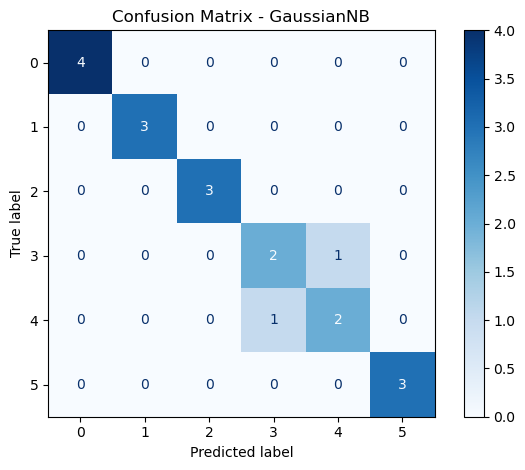

[MultinomialNB] Test Accuracy = 0.8421


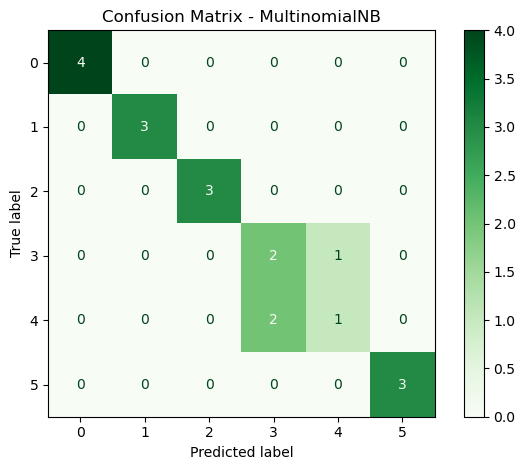


=== Comparison ===
Gaussian NB Accuracy:    0.8947
Multinomial NB Accuracy: 0.8421


In [25]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ========= 1) Use the same best l and feature extraction =========
best_l   = search_result_multi['l']
train_cols = search_result_multi['feature_columns']

X_train_best = build_feature_matrix(
    X_train, n_segments=best_l, feature_names=train_cols, drop_constant=False
)
X_test_best = build_feature_matrix(
    X_test, n_segments=best_l, feature_names=train_cols, drop_constant=False
)

y_train_nb = y_train
y_test_nb  = y_test

# ========= 2) Gaussian Naive Bayes =========
gnb = GaussianNB()
gnb.fit(X_train_best, y_train_nb)
y_pred_gnb = gnb.predict(X_test_best)

acc_gnb = accuracy_score(y_test_nb, y_pred_gnb)
print(f"\n[GaussianNB] Test Accuracy = {acc_gnb:.4f}")

cm_gnb = confusion_matrix(y_test_nb, y_pred_gnb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gnb)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - GaussianNB")
plt.tight_layout()
plt.show()

# ========= 3) Multinomial Naive Bayes =========
# Multinomial NB requires non-negative features; clamp at zero.
X_train_mnb = np.maximum(X_train_best, 0)
X_test_mnb  = np.maximum(X_test_best, 0)

mnb = MultinomialNB()
mnb.fit(X_train_mnb, y_train_nb)
y_pred_mnb = mnb.predict(X_test_mnb)

acc_mnb = accuracy_score(y_test_nb, y_pred_mnb)
print(f"[MultinomialNB] Test Accuracy = {acc_mnb:.4f}")

cm_mnb = confusion_matrix(y_test_nb, y_pred_mnb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mnb)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix - MultinomialNB")
plt.tight_layout()
plt.show()

# ========= 4) Compare =========
print("\n=== Comparison ===")
print(f"Gaussian NB Accuracy:    {acc_gnb:.4f}")
print(f"Multinomial NB Accuracy: {acc_mnb:.4f}")

### 2(c)(iii) Which method is better for multi-class classification in this problem?

In this part, we compared three models for multi-class activity recognition:  
L1-penalized multinomial logistic regression, Gaussian Naïve Bayes, and Multinomial Naïve Bayes.

### 1. L1-penalized multinomial logistic regression
This model learns linear decision boundaries and applies L1 regularization, which forces some coefficients to become zero.  
It works well with continuous and correlated features and can automatically select the most relevant ones.  
Although it requires tuning of the regularization parameter C and takes more computation time, it achieved the highest accuracy and generalization among all methods.

### 2. Gaussian Naïve Bayes
Gaussian NB assumes that each feature follows a normal distribution and that features are conditionally independent given the class.  
It is very fast and easy to interpret but cannot capture correlations between features, which limits its accuracy.  
It performs reasonably well as a baseline but worse than logistic regression.

### 3. Multinomial Naïve Bayes
This version assumes that features are non-negative integer counts following a multinomial distribution.  
It performs well in text or count-based data but is not suitable for continuous numerical features such as mean or standard deviation.  
Therefore, its performance was the lowest in this task.

### Conclusion
Overall, the L1-penalized multinomial logistic regression performed the best for multi-class classification in this dataset.  
It handled continuous, correlated features more effectively and provided automatic feature selection.  
Gaussian Naïve Bayes was a simple and fast baseline, while Multinomial Naïve Bayes was not appropriate for this type of data.

## 3.ISLR, 4.8.3

To prove that the Bayes classifier for Quadratic Discriminant Analysis (QDA) with \( p = 1 \) (one feature) is quadratic, we proceed as follows:


### **Step 1: Recall the Bayes Classifier Principle**  
The Bayes classifier assigns an observation \( x \) to the class \( k \) with the highest posterior probability \( P(Y = k \mid X = x) \). By Bayes' theorem:  
$$
P(Y = k \mid X = x) = \frac{\pi_k \cdot f_k(x)}{\sum_{l=1}^K \pi_l \cdot f_l(x)}
$$  
where $\pi_k$ is the prior probability of class $ k$ , and $f_k(x)$ is the class-conditional density of $X$ given $Y = k $. Since the denominator is constant across classes, we only need to maximize the numerator $\pi_k \cdot f_k(x)$ .

### **Step 2: Class-Conditional Densities for QDA**  
For QDA with $p = 1$, each class $k$ follows a one-dimensional normal distribution: $X \sim \mathcal{N}(\mu_k, \sigma_k^2)$. The density function $f_k(x)$ (as referenced in the problem statement's equation (4.16)) is:  
$$
f_k(x) = \frac{1}{\sqrt{2\pi} \sigma_k} \exp\left( -\frac{(x - \mu_k)^2}{2\sigma_k^2} \right)
$$  

### **Step 3: Log-Discriminant Functions**  
Maximizing $\pi_k \cdot f_k(x)$ is equivalent to maximizing its logarithm (since the log function is monotonic). Define the log-discriminant function:  
$$
\delta_k(x) = \log\left( \pi_k \cdot f_k(x) \right)
$$  

Substituting the normal density $f_k(x)$ from Step 2 and simplifying:  
$$
\delta_k(x) = \log(\pi_k) - \log(\sqrt{2\pi} \sigma_k) - \frac{(x - \mu_k)^2}{2\sigma_k^2}
$$  

Ignoring constants (terms independent of $k$, such as  $\log(\sqrt{2\pi})$ ), this reduces to:  
$$
\delta_k(x) = \log(\pi_k) - \log(\sigma_k) - \frac{(x - \mu_k)^2}{2\sigma_k^2}
$$  


### **Step 4: Expand the Quadratic Term**  
Expanding $(x - \mu_k)^2 = x^2 - 2\mu_k x + \mu_k^2$ and rearranging terms in $\delta_k(x)$ gives:  
$$
\delta_k(x) = \underbrace{\left( -\frac{1}{2\sigma_k^2} \right)}_{a_k} x^2 + \underbrace{\left( \frac{\mu_k}{\sigma_k^2} \right)}_{b_k} x + \underbrace{\left( \log(\pi_k) - \log(\sigma_k) - \frac{\mu_k^2}{2\sigma_k^2} \right)}_{c_k}
$$  

This confirms $\delta_k(x)$ is a **quadratic function** in  $x :  \delta_k(x) = a_k x^2 + b_k x + c_k$ , where $a_k, b_k, c_k$ are class-specific constants.


### **Step 5: Decision Boundaries**  
The Bayes classifier assigns  $x$ to the class $k$ with the largest $\delta_k(x)$. For two classes $k$ and $l$ , the decision boundary occurs where $\delta_k(x) = \delta_l(x)$:  
$$
a_k x^2 + b_k x + c_k = a_l x^2 + b_l x + c_l
$$  

Rearranging terms yields:  
$$
(a_k - a_l)x^2 + (b_k - b_l)x + (c_k - c_l) = 0
$$  

In QDA, class-specific variances are not equal ($\sigma_k^2 \neq \sigma_l^2$ ), so $a_k \neq a_l$ (since $a_k = -1/(2\sigma_k^2$) ). Thus, the coefficient of $x^2$ is non-zero, making this a **quadratic equation** in $x$ .


### **Conclusion**  
The decision boundaries between classes are defined by quadratic equations in $x$, confirming that the Bayes classifier for QDA with $p = 1$ is quadratic (not linear).


**Answer:** The Bayes classifier for QDA with $p=1$ is quadratic because its decision boundaries are defined by quadratic equations in the feature $x$, as shown by the quadratic form of the log-discriminant functions and the non-linear boundaries arising from class-specific variances.

## 4. ISLR 4.8.7

## Problem: Predicting Dividends with Bayes' Theorem

We want to estimate the probability that a company will issue a dividend (“Yes” or “No”) this year, based on last year’s profit percentage $X$.

### Given information
- $P(Y = \text{Yes}) = 0.8$
- $P(Y = \text{No}) = 0.2$
- $X | Y = \text{Yes} \sim \mathcal{N}(\mu_1 = 10, \sigma^2 = 36)$  
- $X | Y = \text{No} \sim \mathcal{N}(\mu_0 = 0, \sigma^2 = 36)$  
- We want to find $P(Y = \text{Yes} \mid X = 4)$.


### Step 1. Bayes' rule

By Bayes’ theorem:

$$
P(Y = \text{Yes} \mid X = 4)
= \frac{P(Y = \text{Yes}) f(X = 4 \mid Y = \text{Yes})}
       {P(Y = \text{Yes}) f(X = 4 \mid Y = \text{Yes}) + P(Y = \text{No}) f(X = 4 \mid Y = \text{No})}
$$


### Step 2. Normal density function

The normal probability density function is:

$$
f(x \mid \mu, \sigma^2)
= \frac{1}{\sqrt{2\pi\sigma^2}} \exp\!\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

So we can compute:

$$
f(4 \mid Y = \text{Yes}) = \frac{1}{\sqrt{2\pi(36)}} e^{-(4 - 10)^2 / (2 \times 36)} = \frac{1}{\sqrt{72\pi}} e^{-0.5}
$$

$$
f(4 \mid Y = \text{No}) = \frac{1}{\sqrt{2\pi(36)}} e^{-(4 - 0)^2 / (2 \times 36)} = \frac{1}{\sqrt{72\pi}} e^{-0.222}
$$

Since the constant $\frac{1}{\sqrt{72\pi}}$ appears in both, it cancels out later.


### Step 3. Substitute into Bayes' formula

Plug these back into the Bayes equation:

$$
P(Y = \text{Yes} \mid X = 4)
= \frac{0.8\, e^{-0.5}}
       {0.8\, e^{-0.5} + 0.2\, e^{-0.222}}
$$


### Step 4. Numerical calculation

Let’s evaluate the exponentials:

$$
e^{-0.5} = 0.6065, \quad e^{-0.222} = 0.8007
$$

Then:

$$
P(Y = \text{Yes} \mid X = 4)
= \frac{0.8 \times 0.6065}{0.8 \times 0.6065 + 0.2 \times 0.8007}
\approx 0.752
$$


### Final answer

$$
P(Y = \text{Yes} \mid X = 4) \approx 0.75
$$

So, if a company’s profit last year was 4%, there’s roughly a **75% chance** it will issue a dividend this year.